In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import BasePredictionWriter

In [40]:
def convert_to_quarterly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO QUARTERLY  #######################

    # Split the session into quarterly intervals
    quarterly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into quarterly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate quarterly intervals
        quarterly_intervals = pd.date_range(start=start.floor(
            '15min'), end=end.ceil('15min'), freq='15min')
        total_duration = (end - start).total_seconds()

        for i in range(len(quarterly_intervals) - 1):
            interval_start = max(start, quarterly_intervals[i])
            interval_end = min(end, quarterly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            quarterly_rows.append({
                'Time': quarterly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    quarterly_df = pd.DataFrame(quarterly_rows)

    quarterly_df = quarterly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    quarterly_df['Time'] = pd.to_datetime(
        quarterly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    quarterly_df = quarterly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = quarterly_df.index.min().normalize()  # 00:00:00
    end_time = quarterly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(
        start=start_time, end=end_time, freq='15min')

    quarterly_df = quarterly_df.reindex(time_range_full, fill_value=0)

    return quarterly_df


def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Energy_Consumption_1h'] = df['Energy_Consumption'].shift(1)
  df['Energy_Consumption_6h'] = df['Energy_Consumption'].shift(6)
  df['Energy_Consumption_12h'] = df['Energy_Consumption'].shift(12)
  df['Energy_Consumption_24h'] = df['Energy_Consumption'].shift(24)
  df['Energy_Consumption_1w'] = df['Energy_Consumption'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Energy_Consumption'].rolling(
      window=24).mean()

  return df


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()


In [41]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return self.X.__len__() - (self.seq_len-1)

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [42]:
class BootstrapSampler(Sampler):
  def __init__(self, data_source, window_size, num_samples=None):
    self.data_source = data_source
    self.window_size = window_size
    self.num_samples = num_samples if num_samples is not None else len(data_source) // 2

  def __iter__(self):
    indices = []
    for _ in range(self.num_samples):
      start_idx = np.random.randint(0, len(self.data_source) - self.window_size + 1)
      indices.extend(range(start_idx, start_idx + self.window_size))
    return iter(indices)

  def __len__(self):
    return self.num_samples

In [43]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    start_date = pd.to_datetime('2021-05-30')
    end_date = pd.to_datetime('2023-05-30')

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_to_quarterly(data)
    data = add_features(data)
    df = filter_data(start_date, end_date, data)

    df = df.dropna()

    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()

    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)

    preprocessing = self.scaler
    preprocessing.fit(self.X_train)  # should only fit to training data

    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    # window_size = round(len(self.X_train)*0.97)
    # bootstrap_sampler = BootstrapSampler(train_dataset, window_size=window_size)
    # train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=bootstrap_sampler, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader
      

In [44]:
class CustomLossFunction(nn.Module):
    def __init__(self):
        super(CustomLossFunction, self).__init__()

    def forward(self, predictions, targets):
        loss = torch.mean((predictions - targets) ** 2) #MSE
        weight = torch.where(predictions < targets, 2.0, 1.0)
        weighted_loss = torch.mean(loss * weight)
        return weighted_loss

In [45]:
class CustomLossFunction2(nn.Module):
    def __init__(self):
        super(CustomLossFunction, self).__init__()

    def forward(self, predictions, targets):
        MAE = torch.mean(torch.abs(predictions - targets))
        MSE = torch.mean((predictions - targets) ** 2)
        loss = MAE if predictions > targets else MSE
        return torch.mean(loss)

In [46]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval, combined_name, model_name):
    super().__init__(write_interval)
    self.output_dir = output_dir
    self.combined_name = combined_name
    self.model_name = model_name

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    filename = os.path.join(self.output_dir, f"{self.combined_name}/predictions_{self.model_name}.pt")
    os.makedirs(os.path.join(self.output_dir, self.combined_name), exist_ok=True)
    torch.save(predictions, filename)

In [47]:
class LightningModel(L.LightningModule):
  def __init__(self, model, criterion, optimizer, learning_rate):
    super().__init__()
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.model = model

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [48]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, seq_len, num_classes):
    super().__init__()
    self.name = "MLP"

    self.all_layers = torch.nn.Sequential(
      torch.nn.Linear(num_features, seq_len),
      torch.nn.ReLU(),
      torch.nn.Linear(seq_len, 25),
      torch.nn.ReLU(),
      torch.nn.Linear(25, num_classes),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    logits = self.all_layers(x)
    return logits

In [49]:
class LSTM(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)
    self.name = "LSTM"

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [50]:
class GRU(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)
    self.name = "GRU"

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [51]:
params = dict(
  input_size = 22,
  seq_len = 12,
  batch_size = 8,
  criterion=CustomLossFunction(),
  optimizer = torch.optim.Adam,
  max_epochs = 20,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 0, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 0, # only work in .py for me
  is_persistent = False, # only work in .py for me
  scaler = MinMaxScaler()
)

## Runs

Lightning

In [52]:
colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
colmod.prepare_data()
colmod.setup(stage=None)

ensemble_models = [
  # MLP(num_features=params['seq_len']*params['input_size'], seq_len=params['batch_size'], num_classes=1),
  GRU(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout']),
  LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout']),
  # RandomForestRegressor(n_estimators=100, random_state=42),
]

model_names = [m.name if isinstance(m, torch.nn.Module) else m.__class__.__name__ for m in ensemble_models]
combined_name = "-".join(model_names)

for _model in ensemble_models:
  if isinstance(_model, torch.nn.Module):
    print(f"-----Training {_model.name} model-----")
    model = LightningModel(model=_model, criterion=params['criterion'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
    pred_writer = CustomWriter(output_dir="Predictions", write_interval="epoch", combined_name=combined_name, model_name=_model.name)
    trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="val_loss", mode="min"), pred_writer], log_every_n_steps=params['batch_size']//2)
    trainer.fit(model, colmod)
    trainer.test(model, colmod)
    trainer.predict(model, colmod, return_predictions=False)
  
  if isinstance(_model, BaseEstimator):
    print(f"-----Training {_model.__class__.__name__} model-----")
    X_train_sample, y_train_sample = resample(colmod.X_train, colmod.y_train, replace=True, n_samples=len(colmod.X_train), random_state=42)
    _model.fit(X_train_sample, y_train_sample.ravel()) # ravel() converts a 2D to a 1D array
    y_pred = _model.predict(colmod.X_test)
    if not os.path.exists(f"Predictions/{combined_name}"):
      os.makedirs(f"Predictions/{combined_name}")
    torch.save(y_pred, f"Predictions/{combined_name}/predictions_{_model.__class__.__name__}.pt")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----Training GRU model-----



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CustomLossFunction | 0      | train
1 | model     | GRU                | 37.3 K | train
---------------------------------------------------------
37.3 K    Trainable params
0         Non-trainable params
37.3 K    Total params
0.149     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 11: 100%|██████████| 5255/5255 [00:57<00:00, 91.60it/s, v_num=46, train_loss_step=0.604, val_loss_step=0.168, val_loss_epoch=1.360, train_loss_epoch=0.999]    


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1751/1751 [00:05<00:00, 293.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        2.3152337074279785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1751/1751 [00:04<00:00, 414.48it/s]
-----Training LSTM model-----


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CustomLossFunction | 0      | train
1 | model     | LSTM               | 49.7 K | train
---------------------------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 5255/5255 [00:43<00:00, 121.05it/s, v_num=47, train_loss_step=0.202, val_loss_step=0.174, val_loss_epoch=1.380, train_loss_epoch=1.010]   


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1751/1751 [00:05<00:00, 320.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        1.4555243253707886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1751/1751 [00:03<00:00, 475.51it/s]


In [53]:
#combine predictions to ensemble
all_predictions = []
lengths = []
folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]
for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  if type(predictions[0]) == torch.Tensor:
    predictions = [item.item() for sublist in predictions for item in sublist]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()
  lengths.append(len(predictions))
  all_predictions.append(predictions)

most_freq_len = max(set(lengths), key=lengths.count)
for i, pred in enumerate(all_predictions):
  if len(pred) < most_freq_len:
    all_predictions[i] += [0] * (most_freq_len - len(pred))
  elif len(pred) > most_freq_len:
    all_predictions[i] = pred[-most_freq_len:]

ensemble_predictions = np.mean(all_predictions, axis=0)
filename = f"{folder_path}/predictions_{combined_name}.pt"
torch.save(ensemble_predictions, filename)

               mse       mae      mape
model                                 
GRU-LSTM  1.027103  0.726460  0.578915
GRU       1.330508  0.872557  2.375659
LSTM      1.065917  0.728669  0.275268


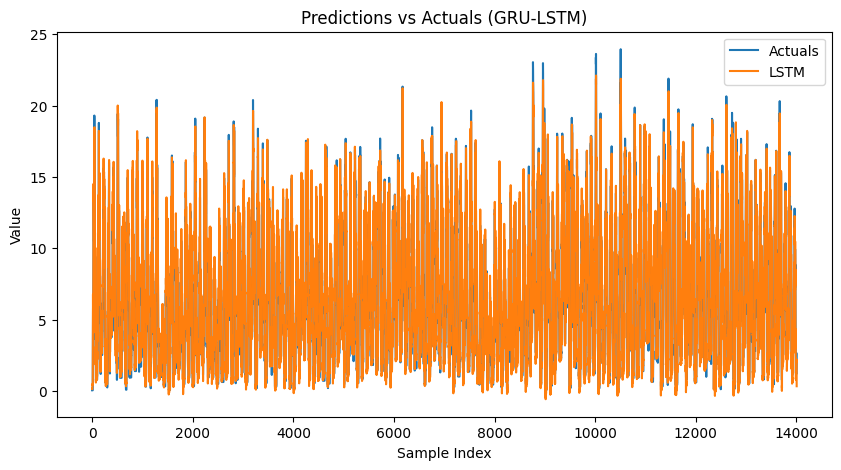

In [54]:
actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

metrics = []
plt.figure(figsize=(10, 5))
for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  model_name = pt_file.split('.')[0].split('_')[-1]

  if len(predictions) > len(actuals_flat):
    predictions = predictions[-len(actuals_flat):]
  if type(predictions[0]) == torch.Tensor: 
    predictions = [item.item() for sublist in predictions for item in sublist]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()

  metrics.append({
    'model': model_name,
    'mse': mean_squared_error(predictions, actuals_flat),
    'mae': mean_absolute_error(predictions, actuals_flat),
    'mape': mean_absolute_percentage_error(predictions, actuals_flat)})

loss_func_df = pd.concat([pd.DataFrame([m]) for m in metrics])
loss_func_df.set_index('model', inplace=True)
print(loss_func_df)
plt.plot(actuals_flat, label='Actuals')
plt.plot(predictions, label=model_name)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Predictions vs Actuals ({combined_name})')
plt.legend()

plt.savefig(f'{folder_path}/predictions_vs_actuals_{combined_name}.png')
plt.show()

Model Name: GRU-LSTM
Percentage of predictions below 95%: 69.80%
Percentage of predictions above 105%: 15.60%
Total percentage of predictions below actuals: 78.00%


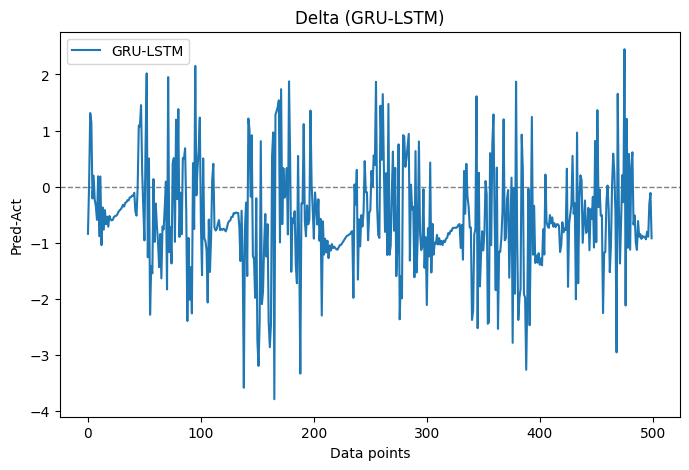

In [55]:
actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

predictions = []
metrics = []

actuals_flat = actuals_flat[-500:]

plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Delta ({combined_name})')
plt.xlabel('Data points')
plt.ylabel('Pred-Act')
for i, pt_file in enumerate(pt_files):
    file_path = os.path.join(folder_path, pt_file)
    predictions = torch.load(file_path)
    model_name = pt_file.split('.')[0].split('_')[-1]

    if len(predictions) > len(actuals_flat):
        predictions = predictions[-len(actuals_flat):]
    if type(predictions[0]) == torch.Tensor: 
        predictions = [item.item() for sublist in predictions for item in sublist]
    elif type(predictions[0]) == np.float64:
        predictions = predictions.tolist()
    
    predictions = predictions[-500:]

    diff = np.array(predictions) - np.array(actuals_flat)
    plt.plot(diff, label=model_name)

    below_threshold = np.array(predictions) < (np.array(actuals_flat) * 0.95)
    above_threshold = np.array(predictions) > (np.array(actuals_flat) * 1.05)
    total_below_actuals = np.sum(np.array(predictions) < np.array(actuals_flat))
    percentage_below_threshold = np.sum(below_threshold) / len(predictions) * 100
    percentage_above_threshold = np.sum(above_threshold) / len(predictions) * 100
    percentage_total_below_actuals = total_below_actuals / len(predictions) * 100
    print(f"Model Name: {model_name}")
    print(f"Percentage of predictions below 95%: {percentage_below_threshold:.2f}%")
    print(f"Percentage of predictions above 105%: {percentage_above_threshold:.2f}%")
    print(f"Total percentage of predictions below actuals: {percentage_total_below_actuals:.2f}%")
    break

plt.legend()
plt.show()


In [59]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 54893), started 0:24:51 ago. (Use '!kill 54893' to kill it.)

In [60]:
!tasklist | findstr tensorboard # find tensorboard pid
# !taskkill /PID 16220 /F # kill tensorboard with pid

zsh:1: command not found: tasklist
zsh:1: command not found: findstr


## SHAP

In [56]:
feature_names = ['Energy_Consumption', 'Session_Count', 'Day_of_Week', 'Hour_of_Day',
                 'Month_of_Year', 'Year', 'Day/Night', 'IsHoliday', 'Weekend', 'HourSin',
                 'HourCos', 'DayOfWeekSin', 'DayOfWeekCos', 'MonthOfYearSin',
                 'MonthOfYearCos', 'Energy_Consumption_1h', 'Energy_Consumption_6h',
                 'Energy_Consumption_12h', 'Energy_Consumption_24h',
                 'Energy_Consumption_1w', 'Energy_Consumption_rolling', 'Season']

### Feature Importance Using KernelExplainer 

In [61]:
def compute_shap_values(model, dataloader, feature_names, nsamples=100, agg_func=np.mean):
  ## Compute SHAP values ##
  X, _ = next(iter(dataloader))
  batch_size, seq_len, input_size = X.shape

  # To use KernalExplainer, we need to convert X to numpy and flatten it
  X_numpy = X.detach().cpu().numpy()
  # (batch_size, seq_len * input_size) / (8, 312) # what does -1 do?
  X_flat = X_numpy.reshape(batch_size, -1)
  # X_flat = agg_func(X_numpy, axis=1) # (batch_size, input_size) / (8, 26)

  # Define prediction function for shape values
  def predict_fn(X_numpy):
    X_tensor = torch.from_numpy(X_numpy).float()
    # (batch_size, seq_len, input_size) / (8, 12, 26)
    X_tensor = X_tensor.view(-1, seq_len, input_size)
    out = model(X_tensor)  # shape: (batch_size, 1)
    return out.detach().cpu().numpy().flatten()

  # Use X_flat as a background dataset to estimate expected values
  background = X_flat

  # Create an explainer object
  explainer = shap.KernelExplainer(predict_fn, background)

  # Compute SHAP values
  shap_values = explainer.shap_values(X_flat, nsamples=nsamples)

  # Aggregate SHAP values
  shap_values_reshaped = shap_values.reshape(batch_size, seq_len, input_size)
  shap_values_aggregated = agg_func(
      shap_values_reshaped, axis=1)  # (batch_size, input_size)

  print(f"SHAP values shape: {shap_values_aggregated.shape}")

  ## PLotting SHAP values ##
  shap.summary_plot(shap_values_aggregated, feature_names,
                    plot_type='bar', show=False, max_display=26, plot_size=(20, 10))
  plt.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=700)
  plt.show()

  shap.waterfall_plot(shap.Explanation(values=shap_values_aggregated[0], base_values=explainer.expected_value,
                      data=X_flat[0], feature_names=feature_names), show=False, max_display=26)
  plt.show()
  plt.savefig('shap_waterfall_plot.png', dpi=700, )

  shap.waterfall_plot(shap.Explanation(values=shap_values_aggregated[1], base_values=explainer.expected_value,
                      data=X_flat[1], feature_names=feature_names), show=False, max_display=26)
  plt.show()
  plt.savefig('shap_waterfall_plot_100.png', dpi=700, bbox_inches='tight')

  return shap_values_aggregated


#shap_values = compute_shap_values(model, colmod.predict_dataloader(), feature_names, nsamples=100, agg_func=np.mean)

### Feature Importance Using DeepExplainer 

In [62]:
def compute_shap_values_using_deep_explainer(model, dataloader, feature_names, agg_func=np.mean):
  ## Compute SHAP values ##
  model.eval()  # Ensure the model is in evaluation mode
  X, _ = next(iter(dataloader))
  batch_size, seq_len, input_size = X.shape

  # Create a DeepExplainer object
  explainer = shap.DeepExplainer(model, X)

  # Compute SHAP values
  shap_values = explainer.shap_values(X, check_additivity=False)

  shap_values_agg = agg_func(shap_values.reshape(
      batch_size, seq_len, input_size), axis=1)  # (batch_size, input_size)

  shap.summary_plot(
      shap_values=shap_values_agg,
      features=X[:, -1, :].numpy(),
      feature_names=feature_names,
      plot_type='bar',
      show=False,
      max_display=26,
      plot_size=(20, 10)
  )
  plt.savefig('shap_summary_plot_deep_explainer.png',
              bbox_inches='tight', dpi=700)
  plt.show()

  # Waterfall plot for the first sample
  shap.waterfall_plot(shap.Explanation(values=shap_values_agg[0], base_values=explainer.expected_value,
                      data=X[0, -1, :].numpy(), feature_names=feature_names), show=False, max_display=26)
  plt.savefig('shap_waterfall_plot_deep_explainer.png',
              dpi=700, bbox_inches='tight')
  plt.show()

  # Waterfall plot for the second sample
  shap.waterfall_plot(shap.Explanation(values=shap_values_agg[1], base_values=explainer.expected_value,
                      data=X[1, -1, :].numpy(), feature_names=feature_names), show=False, max_display=26)
  plt.savefig('shap_waterfall_plot_deep_explainer_100.png',
              dpi=700, bbox_inches='tight')
  plt.show()

  # Beeswarm plot
  shap_values_explanation = shap.Explanation(
      values=shap_values_agg, base_values=explainer.expected_value, data=X[:, -1, :].numpy(), feature_names=feature_names)
  shap.plots.beeswarm(shap_values_explanation, max_display=26, show=False)
  plt.show()

  # Violin plot
  shap.plots.violin(shap_values_explanation, max_display=26, show=False)
  plt.show()

  # Shap scatter plot
  shap.decision_plot(explainer.expected_value,
                     shap_values_agg[0], feature_names=feature_names, show=False)
  plt.show()

  # Save the SHAP values to a CSV file
  shap_values_df = pd.DataFrame(shap_values_agg, columns=feature_names)
  shap_values_df.to_csv('shap_values_deep_explainer.csv', index=False)

#compute_shap_values_using_deep_explainer(model, colmod.predict_dataloader(), feature_names, agg_func=np.mean)